In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table

Flux = np.array([1.0,2.0,3.0])
Unc = np.array([0.1,0.1,0.1])
Wave = np.array([4.0,5.0,6.0])
Spec = Table([Wave, Flux, Unc],names = ('Wavelength','Flux','Unc'))#, dtype=('float32','float32','float32'))
Spec['Wavelength'].format = '.6f'
Spec['Flux'].format = '.6f'
Spec['Unc'].format = '.5f'
Spec.write('test.tbl',format='ascii',overwrite=True)
Spec_hdu = fits.BinTableHDU(Spec, name='Spectrum')
#hdul = fits.HDUList([Cube_hdu,Spec_hdu])
Spec_hdu.writeto('test.fits', overwrite = True)

In [2]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

In [3]:
def wcss2(hdu):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    x = hdu['NAXIS1']
    y = hdu['NAXIS2']
    recx, recy = w.wcs_pix2world([1, x, x, 1, 1],[1, 1, y, y, 1],1)
    return [recx, recy]

In [4]:
def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

In [5]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
                              
        f, ax = plt.subplots(1, 1, figsize=[15,9])
        for mode in data_mode:
            file_n = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            if(mode[0:2] == 'LL'):
                an = np.min([yy[0], mm[1]-yy[0]-1, n_pix-2])
            else:
                an = np.min([xx[0], mm[0]-xx[0]-1, n_pix-2])

            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for j in range(0,an+1,1):
                if(mode[0:2] == 'SL'):
                    flux_part = flux[xx[0]-j:xx[0]+j+1,:]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,:]
                else:
                    flux_part = flux[:,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[:,yy[0]-j:yy[0]+j+1]
                mask_part1 = ~np.isnan(flux_part.sum(axis=2))
                flux_part[np.isnan(flux_part.sum(axis=2))] = 0
                mask_part2 = (flux_part/flux_part_u).mean(axis=2)>5
                mask_part = mask_part1*mask_part2
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=0)
                flux_out = flux_part/part_pix

                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=0)
                flux_out_u = np.sqrt(flux_part_u)/part_pix
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    Spec = Table([wave, flux_out, flux_out_u], names = ('Wavelength','Flux','Uncertainty'))
                    Spec['Wavelength'].format = '.5f'
                    Spec['Flux'].format = '.5f'
                    Spec['Uncertainty'].format = '.6f'
                    dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
                    if(os.path.exists(dirs) != True):
                        os.makedirs(dirs)
                    Spec.write(dirs+'/{0}_{1}pixel_width.tbl'.format(name.split('_')[0]+mode, str(2*j+1)),format='ascii.ipac',overwrite=True)

                    par = (j)*np.abs(flux_header['CDELT1'])*3600
                    if(mode == O2):
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[j], elinewidth=1, label='$width:{0}\ pixel$'.format(str(2*j+1)))
                        ax.legend(loc=2, fontsize='x-small')
                    else:
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[j], elinewidth=1)
                

#    for i in range(0,4):
        ax.set_xscale('log')
        ax.set_yscale('log')
#            ax.set_xlim([1.5,10**2])
        ax.set_ylim(0.1)
        ax.set_xlabel('$\lambda\ (um)$', fontsize=18)
        ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
        ax.set_title('{0}({1})'.format(name.split('_')[0],data_mode[num]), fontsize=20)
        ax.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)
        dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        f.savefig(dirs+'/{0}_Spec_row.png'.format(name.split('_')[0]))
    return

In [6]:
#Spectra_ext(['ngc4826_Sy2'],5,15,'LL2')

In [7]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        nnaa = '/Users/zhangl/desktop/SINGS/Ancillaryimg/'+name.split('_')[0]
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
                              
        f, ax = plt.subplots(1, 1, figsize=[15,9])

        for mode in data_mode:
            file_n = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
            print(xx,yy)
            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            if(data_mode[num][0:2] == 'LL'):
                an = np.min([yy[0], mm[1]-yy[0]-1, n_pix-2])
            else:
                an = np.min([xx[0], mm[0]-xx[0]-1, n_pix-2])

            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for j in range(1,an+1,1):
                if(data_mode[num][0:2] == 'SL'):
                    flux_part = flux[xx[0]-j:xx[0]+j+1,:]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,:]
                    flux_cen = flux[xx[0]-j+1:xx[0]+j,:]
                    flux_cen_u = flux_u[xx[0]-j+1:xx[0]+j,:]
                else:
                    flux_part = flux[:,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[:,yy[0]-j:yy[0]+j+1]
                    flux_cen = flux[:,yy[0]-j+1:yy[0]+j]
                    flux_cen_u = flux_u[:,yy[0]-j+1:yy[0]+j]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)

                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    par = (j)*np.abs(flux_header['CDELT1'])*3600
                    if(mode == O2):
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[j], lw=1, label='$width:{0}\ pixel$'.format(str(2*j+1)))
                        ax.legend(loc=2, fontsize='x-small')
                    else:
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[j], lw=1)
                

#    for i in range(0,4):
        ax.set_xscale('log')
        ax.set_yscale('log')
#            ax.set_xlim([1.5,10**2])
#        ax.set_ylim(0.1)
        ax.set_xlabel('$\lambda\ (um)$', fontsize=18)
        ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
        ax.set_title('{0}'.format(name.split('_')[0]), fontsize=20)
#        ax.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)

    return

In [18]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        nnaa = '/Users/zhangl/desktop/SINGS/Ancillaryimg/'+name.split('_')[0]
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
                              
        f, ax = plt.subplots(1, 1, figsize=[15,9])

        for mode in data_mode:
            file_n = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
            print(xx,yy)
            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            if(mode[0:2] == 'LL'):
                an = np.min([yy[0], mm[1]-yy[0]-1, n_pix-2])
            else:
                an = np.min([xx[0], mm[0]-xx[0]-1, n_pix-2])

            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for j in range(1,an+1,1):
                if(mode == 'SL2'):
                    yb = 0
                    yt = 2*yy[0]
                    ww = yt - yb
                    flux_part = flux[xx[0]-j:xx[0]+j+1,yb:yt]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,yb:yt]
                    flux_cen = flux[xx[0]-j+1:xx[0]+j,yb:yt]
                    flux_cen_u = flux_u[xx[0]-j+1:xx[0]+j,yb:yt]
                if(mode == 'SL1'):
                    yb = 2*yy[0] - mm[1]
                    yt = mm[1]
                    ww = yt - yb
                    flux_part = flux[xx[0]-j:xx[0]+j+1,yb:yt]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,yb:yt]
                    flux_cen = flux[xx[0]-j+1:xx[0]+j,yb:yt]
                    flux_cen_u = flux_u[xx[0]-j+1:xx[0]+j,yb:yt]
                if(mode == 'LL2'):
                    xl = 0
                    xr = 2*xx[0]
                    ww = xr - xl
                    flux_part = flux[xl:xr,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[xl:xr,yy[0]-j:yy[0]+j+1]
                    flux_cen = flux[xl:xr,yy[0]-j+1:yy[0]+j]
                    flux_cen_u = flux_u[xl:xr,yy[0]-j+1:yy[0]+j]
                if(mode == 'LL1'):
                    xl = 2*xx[0] - mm[0]
                    xr = mm[0]
                    ww = xr - xl
                    flux_part = flux[xl:xr,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[xl:xr,yy[0]-j:yy[0]+j+1]
                    flux_cen = flux[xl:xr,yy[0]-j+1:yy[0]+j]
                    flux_cen_u = flux_u[xl:xr,yy[0]-j+1:yy[0]+j]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)*2*ww/(part_pix - cen_pix)
                flux_cen = flux_cen*(2*j - 1)*ww/cen_pix

                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)*2*ww/(part_pix - cen_pix)
                flux_cen_u = flux_cen_u*(2*j - 1)*ww/cen_pix
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    par = (j)*np.abs(flux_header['CDELT1'])*3600
                    if(mode == O2):
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[j], lw=1, label='$width:{0}\ pixel$'.format(str(2*j+1)))
                        ax.legend(loc=2, fontsize='x-small')
                    else:
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[j], lw=1)
                

#    for i in range(0,4):
        ax.set_xscale('log')
        ax.set_yscale('log')
#            ax.set_xlim([1.5,10**2])
#        ax.set_ylim(0.1)
        ax.set_xlabel('$\lambda\ (um)$', fontsize=18)
        ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
        ax.set_title('{0}'.format(name.split('_')[0]), fontsize=20)
#        ax.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)

    return

In [5]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        nnaa = '/Users/zhangl/desktop/SINGS/Ancillaryimg/'+name.split('_')[0]
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]

        f = plt.figure(figsize=[15,20])
        gs0 = gridspec.GridSpec(2, 2)
        for num in range(0,len(data_mode)):

            gs00 = gridspec.GridSpecFromSubplotSpec(12, 3, subplot_spec=gs0[num//2,num%2])

            file_n = nnmm +'{0}_on2_{1}.fits'.format(data_mode[num],O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(data_mode[num],O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            mask1 = wave>data_norm[num][0]
            mask2 = wave<data_norm[num][1]
            mask = mask1*mask2
            fmean_c = (flux[xx[0]][yy[0]][mask]).mean()
            flux_max = flux[xx[0]][yy[0]]/fmean_c
            flux_max_u = flux_u[xx[0]][yy[0]]/fmean_c

            Spec = Table([wave, flux[xx[0]][yy[0]], flux_u[xx[0]][yy[0]]], names = ('Wavelength','Flux','Uncertainty'))
            Spec['Wavelength'].format = '.5f'
            Spec['Flux'].format = '.5f'
            Spec['Uncertainty'].format = '.6f'
            dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            Spec.write(dirs+'/{0}_CenPix.tbl'.format(name.split('_')[0]+data_mode[num]),format='ascii.ipac',overwrite=True)

            ax1 = plt.Subplot(f, gs00[:-5, :])
#                ax1.plot(wave, flux_max, 'k-', label='$central\ pixel$')
            ax1.errorbar(wave, flux_max, flux_max_u, c='k',ls='-', label='$central\ pixel$')
            fluc_u = []
            sigma = []
            raddd = []

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    fmean = (flux_out[mask]).mean()

                    Spec = Table([wave, flux_out, flux_out_u], names = ('Wavelength','Flux','Uncertainty'))
                    Spec['Wavelength'].format = '.5f'
                    Spec['Flux'].format = '.5f'
                    Spec['Uncertainty'].format = '.6f'
                    dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
                    Spec.write(dirs+'/{0}_Out{1}PixC.tbl'.format(name.split('_')[0]+data_mode[num], str(i)),format='ascii.ipac',overwrite=True)

                    flux_out = flux_out/fmean
                    flux_out_u = flux_out_u/fmean
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    ax1.errorbar(wave, flux_out, flux_out_u, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    fluc_u.append(snr)
#                        masssk = flux_out/flux_max>0
                    ratio = flux_out/flux_max
                    sigma.append(ratio.std())
                    raddd.append(par)


            fluc_u = np.array(fluc_u)
            sigma = np.array(sigma)
            raddd = np.array(raddd)
            plt.setp(ax1.get_xticklabels(), visible=False)
            f.add_subplot(ax1)
                

#    for i in range(0,4):
            ax2 = plt.Subplot(f, gs00[-4:-2, :])
            ax2.scatter(raddd, sigma, color='k')
            plt.setp(ax2.get_xticklabels(), visible=False)
            f.add_subplot(ax2)
        
            ax3 = plt.Subplot(f, gs00[-2:, :], sharex=ax2)
            ax3.scatter(raddd, fluc_u, color='k')
            ax3.axhline(sn, color='r', ls='-', label='$SNR\ =\ $'+str(sn))
            f.add_subplot(ax3)
            ax1.set_xscale('log')
            ax1.set_yscale('log')
#            ax2.set_xscale('log')
#            ax2.set_yscale('log')
#            ax3.set_xscale('log')
            ax3.set_yscale('log')
            ax1.set_ylim([10**-1,10**1])
            ax2.set_xlim([1.5,30])
            ax2.set_ylim([0,0.3])
            if(len(sigma)!=0):
                ax3.set_ylim([1,np.max(fluc_u)*1.5])
            ax1.set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax3.set_xlabel('$R\ (\'\')$', fontsize=18)
            ax1.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
            ax2.set_ylabel('$\sigma_{R\_F}$', fontsize=18)
            ax3.set_ylabel('$SNR$', fontsize=18)
            ax1.set_title('{0}({1})'.format(name.split('_')[0],data_mode[num]), fontsize=20)
            ax1.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)
            ax1.legend(loc=2, fontsize='x-small')
            ax3.legend(loc=1, fontsize='x-small')
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            f.savefig(dirs+'/{0}_Spec_Cal.png'.format(name.split('_')[0]))
    return

In [10]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        nnaa = '/Users/zhangl/desktop/SINGS/Ancillaryimg/'+name.split('_')[0]
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]

        f = plt.figure(figsize=[15,20])
        gs0 = gridspec.GridSpec(1, 1)
        gs00 = gridspec.GridSpecFromSubplotSpec(12, 3, subplot_spec=gs0[0,0])
        for num in range(0,len(data_mode)):

            file_n = nnmm +'{0}_on2_{1}.fits'.format(data_mode[num],O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(data_mode[num],O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            mask1 = wave>data_norm[num][0]
            mask2 = wave<data_norm[num][1]
            mask = mask1*mask2
            fmean_c = (flux[xx[0]][yy[0]][mask]).mean()
            flux_max = flux[xx[0]][yy[0]]/fmean_c
            flux_max_u = flux_u[xx[0]][yy[0]]/fmean_c

            Spec = Table([wave, flux[xx[0]][yy[0]], flux_u[xx[0]][yy[0]]], names = ('Wavelength','Flux','Uncertainty'))
            Spec['Wavelength'].format = '.5f'
            Spec['Flux'].format = '.5f'
            Spec['Uncertainty'].format = '.6f'
            dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            Spec.write(dirs+'/{0}_CenPix.tbl'.format(name.split('_')[0]+data_mode[num]),format='ascii.ipac',overwrite=True)

            ax1 = plt.Subplot(f, gs00[:-5, :])
#                ax1.plot(wave, flux_max, 'k-', label='$central\ pixel$')
            ax1.errorbar(wave, flux_max, flux_max_u, c='k',ls='-', label='$central\ pixel$')
            fluc_u = []
            sigma = []
            raddd = []

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    fmean = (flux_out[mask]).mean()

                    Spec = Table([wave, flux_out, flux_out_u], names = ('Wavelength','Flux','Uncertainty'))
                    Spec['Wavelength'].format = '.5f'
                    Spec['Flux'].format = '.5f'
                    Spec['Uncertainty'].format = '.6f'
                    dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
                    Spec.write(dirs+'/{0}_Out{1}PixC.tbl'.format(name.split('_')[0]+data_mode[num], str(i)),format='ascii.ipac',overwrite=True)

                    flux_out = flux_out/fmean
                    flux_out_u = flux_out_u/fmean
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    ax1.errorbar(wave, flux_out, flux_out_u, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    fluc_u.append(snr)
#                        masssk = flux_out/flux_max>0
                    ratio = flux_out/flux_max
                    sigma.append(ratio.std())
                    raddd.append(par)


            fluc_u = np.array(fluc_u)
            sigma = np.array(sigma)
            raddd = np.array(raddd)
            plt.setp(ax1.get_xticklabels(), visible=False)
            f.add_subplot(ax1)
                

#    for i in range(0,4):
            ax2 = plt.Subplot(f, gs00[-4:-2, :])
            ax2.scatter(raddd, sigma, color='k')
            plt.setp(ax2.get_xticklabels(), visible=False)
            f.add_subplot(ax2)
        
            ax3 = plt.Subplot(f, gs00[-2:, :], sharex=ax2)
            ax3.scatter(raddd, fluc_u, color='k')
            ax3.axhline(sn, color='r', ls='-', label='$SNR\ =\ $'+str(sn))
            f.add_subplot(ax3)
            ax1.set_xscale('log')
            ax1.set_yscale('log')
#            ax2.set_xscale('log')
#            ax2.set_yscale('log')
#            ax3.set_xscale('log')
            ax3.set_yscale('log')
            ax1.set_ylim([10**-1,10**1])
            ax2.set_xlim([1.5,30])
            ax2.set_ylim([0,0.3])
            if(len(sigma)!=0):
                ax3.set_ylim([1,np.max(fluc_u)*1.5])
            ax1.set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax3.set_xlabel('$R\ (\'\')$', fontsize=18)
            ax1.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
            ax2.set_ylabel('$\sigma_{R\_F}$', fontsize=18)
            ax3.set_ylabel('$SNR$', fontsize=18)
            ax1.set_title('{0}({1})'.format(name.split('_')[0],data_mode[num]), fontsize=20)
            ax1.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)
            ax1.legend(loc=2, fontsize='x-small')
            ax3.legend(loc=1, fontsize='x-small')
            plt.rc('xtick', labelsize=18)
            plt.rc('ytick', labelsize=18)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            f.savefig(dirs+'/{0}_Spec_Cal.png'.format(name.split('_')[0]))
    return

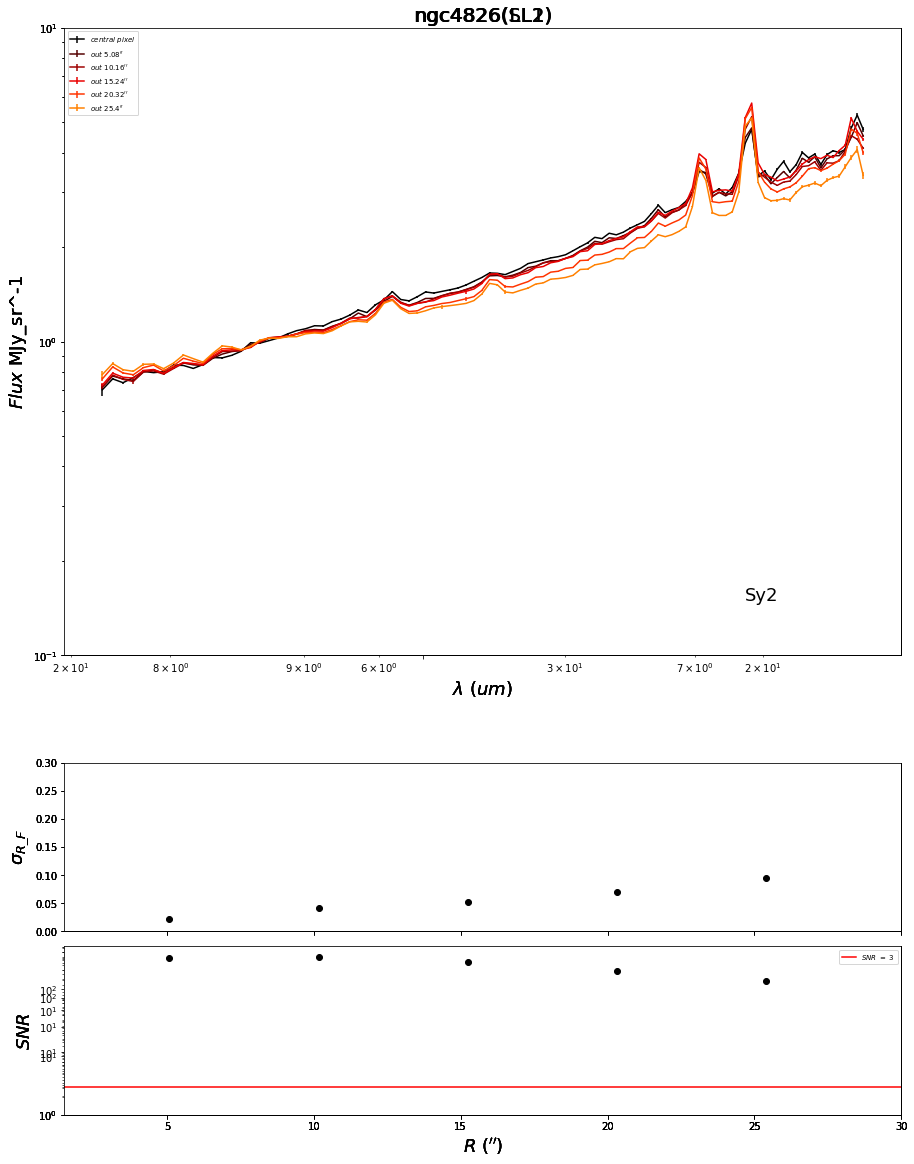

In [11]:
Spectra_ext(['ngc4826_Sy2'], 3, 10, 'LL2')

In [59]:
def Spectra_ext(gal_name, sn, n_pix, O2):
    import os
    import numpy as np
    import aplpy
    from astropy import wcs
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from astropy.io import fits
    from astropy.table import Table

#gal_list = open('../subsam_LINER.txt','r')
#gal_name = gal_list.readlines()
#gallist = ['ngc4826', 'ngc4569', 'ngc3351', 'ngc4736']
    data_mode = ['SL2','SL1','LL2','LL1']
    data_norm = [[5.7, 5.8], [8.0, 8.4], [14.5, 15.2], [23, 24]]
#    data_norm = [[6.5, 6.7], [9.2, 9.5], [14.5, 15.2], [23, 24]]

#    O2 = 'LL2'
    for name in gal_name:
        f = plt.figure(figsize=[15,20])
        gs0 = gridspec.GridSpec(2, 2)
        nnmm = '/Users/zhangl/desktop/SINGS/Cube/{0}/'.format(name.split('_')[0])
#        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        for num in range(0, len(data_mode)):
            file_n = nnmm + '{0}_DR5_{1}_cube.fits'.format(name.split('_')[0], data_mode[num])
            file_u = nnmm + '{0}_DR5_{1}_cube_unc.fits'.format(name.split('_')[0], data_mode[num])
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))

            gs00 = gridspec.GridSpecFromSubplotSpec(12, 3, subplot_spec=gs0[num//2,num%2])

            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpixx[0],0))]
            yy = [int(round(crpixy[0],0))]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            mask1 = wave>data_norm[num][0]
            mask2 = wave<data_norm[num][1]
            mask = mask1*mask2
            fmean_c = (flux[xx[0]][yy[0]][mask]).mean()
            flux_max = flux[xx[0]][yy[0]]/fmean_c
            flux_max_u = flux_u[xx[0]][yy[0]]/fmean_c

            ax1 = plt.Subplot(f, gs00[:-5, :])
#                ax1.plot(wave, flux_max, 'k-', label='$central\ pixel$')
            ax1.errorbar(wave, flux_max, flux_max_u, c='k',ls='-', label='$central\ pixel$')
            fluc_u = []
            sigma = []
            raddd = []

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    fmean = (flux_out[mask]).mean()

                    flux_out = flux_out/fmean
                    flux_out_u = flux_out_u/fmean
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    ax1.errorbar(wave, flux_out, flux_out_u, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    fluc_u.append(snr)
#                        masssk = flux_out/flux_max>0
                    ratio = flux_out/flux_max
                    sigma.append(ratio.std())
                    raddd.append(par)


            fluc_u = np.array(fluc_u)
            sigma = np.array(sigma)
            raddd = np.array(raddd)
            plt.setp(ax1.get_xticklabels(), visible=False)
            f.add_subplot(ax1)
                

#    for i in range(0,4):
            ax2 = plt.Subplot(f, gs00[-4:-2, :])
            ax2.scatter(raddd, sigma, color='r', marker='^')
            plt.setp(ax2.get_xticklabels(), visible=False)
            f.add_subplot(ax2)
        
            ax3 = plt.Subplot(f, gs00[-2:, :], sharex=ax2)
            ax3.scatter(raddd, fluc_u, color='r', marker='^')
            ax3.axhline(sn, color='r', ls='-', label='$SNR\ =\ $'+str(sn))
            f.add_subplot(ax3)
            ax1.set_xscale('log')
            ax1.set_yscale('log')
#            ax2.set_xscale('log')
#            ax2.set_yscale('log')
#            ax3.set_xscale('log')
            ax3.set_yscale('log')
            ax1.set_ylim([10**-1,10**1])
            ax2.set_xlim([1.5,30])
            ax2.set_ylim([0,0.3])
            if(len(sigma)!=0):
                ax3.set_ylim([1,np.max(fluc_u)*1.5])
            ax1.set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax3.set_xlabel('$R\ (\'\')$', fontsize=18)
            ax1.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=18)
            ax2.set_ylabel('$\sigma_{R\_F}$', fontsize=18)
            ax3.set_ylabel('$SNR$', fontsize=18)
            ax1.set_title('{0}({1})'.format(name.split('_')[0],data_mode[num]), fontsize=20)
            ax1.text(wave[-20], 0.15, name.split('_')[1], fontsize=18)
            ax1.legend(loc=2, fontsize='x-small')
            ax3.legend(loc=1, fontsize='x-small')
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            f.savefig(dirs+'/{0}_Spec_Cal.png'.format(name.split('_')[0]))
    return

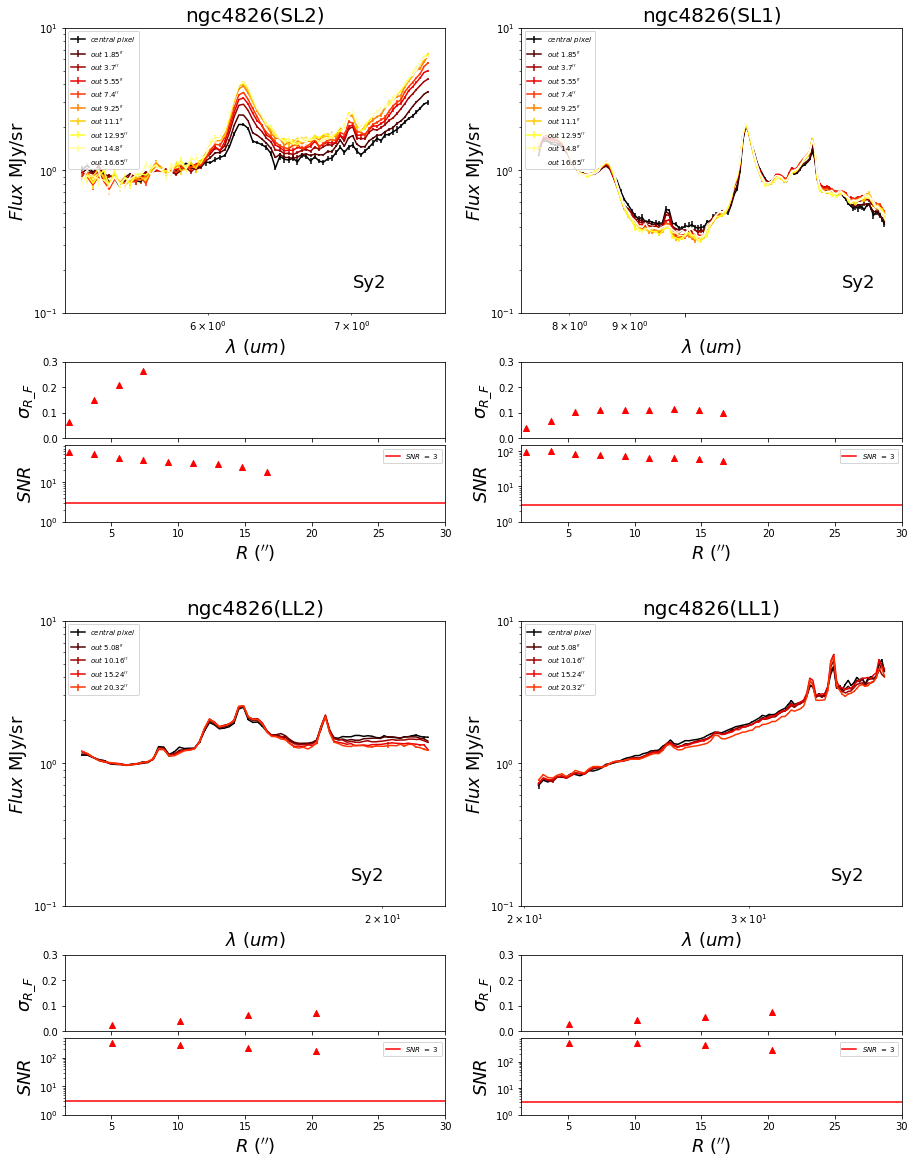

In [60]:
Spectra_ext(['ngc4826_Sy2'], 3, 10, 'LL2')